In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
import time
import scipy.optimize as opt

plt.rcParams["figure.figsize"] = (20, 10)

Function: $y = \frac{exp(-1*x)}{2+3*x}$

In [277]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

const_lr = lambda n, start: start
exp_lr = lambda n, start: start * np.exp(-0.01 * n)

In [278]:
start_point = [2, 4, 5]

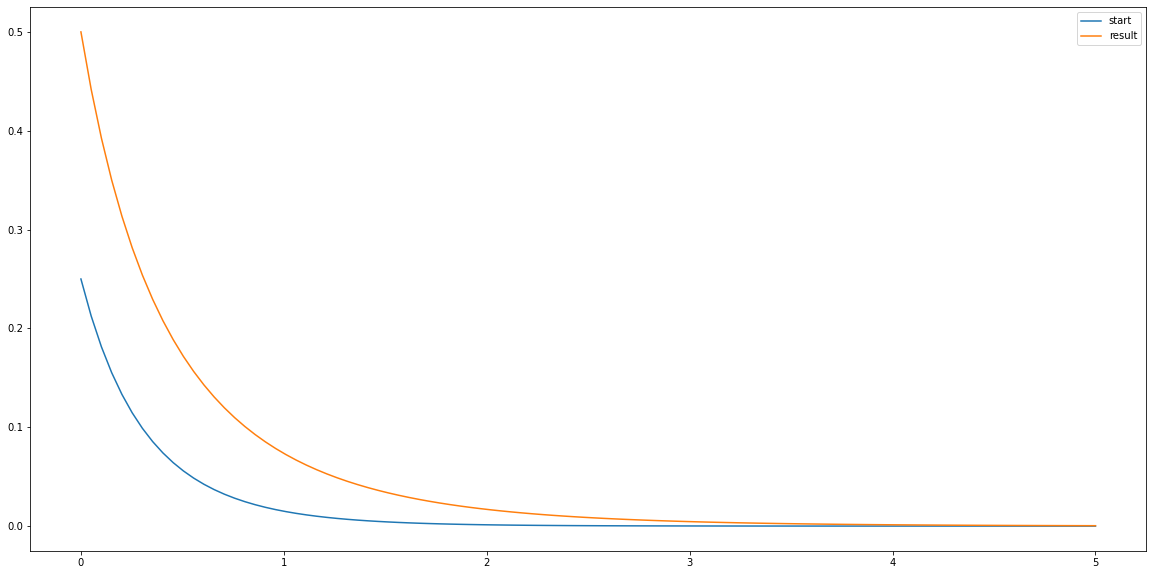

In [279]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

plt.plot(xs, func(xs, *start_point), label='start')
plt.plot(xs, ys, label='result')

plt.legend()

# GD

In [280]:
def partial(f, i, x):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return np.array([partial(f, i, x) for i in range(len(x))])


def minibatch_grad(func, x, batch=30):
    return grad(func, x)


def cancel_condition(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6


def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start

    points = list()
    grads = list()
    loss = list()
    points.append(x)
    for i in range(1, epoch):
        grads.append(np.linalg.norm(minibatch_grad(f, x, batch)))
        loss.append(f(x))
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points.append(x)

        if np.linalg.norm(grad(f, x)) < 1e-7:
            break

    return [np.array(points), np.array(grads), np.array(loss)]


def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30)

Итераций 24261


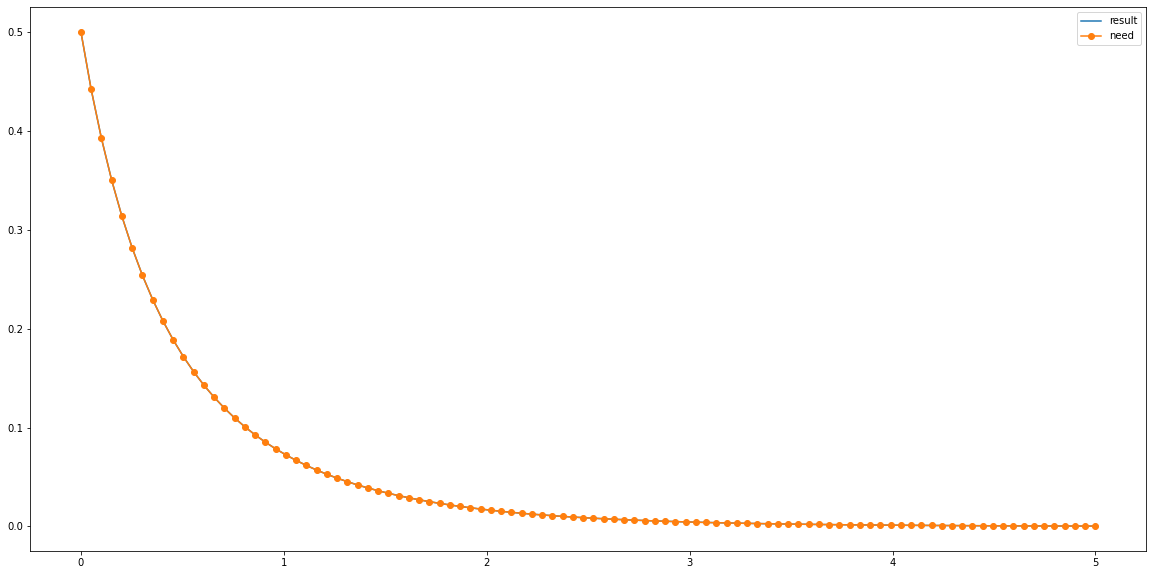

In [281]:
gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)

print("Итераций", len(gd_points))

ans = gd_points[-1]

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-', label='result')
plt.plot(xs, ys, '-o', label='need')
plt.legend()

# Adam

In [282]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0, 0])
    prev_v = np.array([0, 0, 0])

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        grads.append(np.linalg.norm(gr))
        loss.append(f(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss)]

Итераций:  627


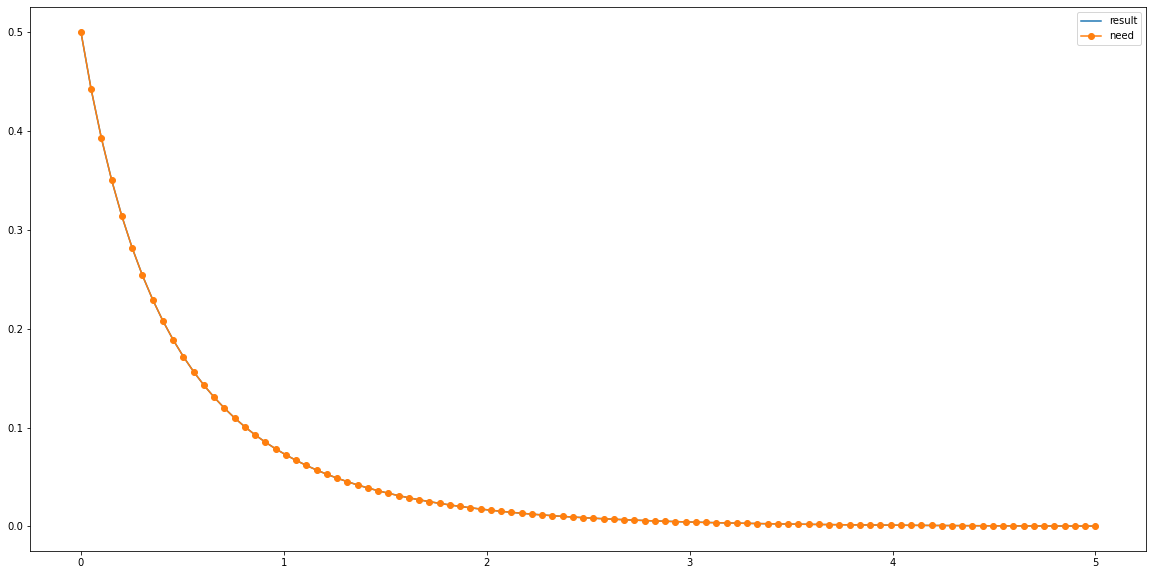

In [283]:
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point,
                                          lr_strategy=exp_lr,
                                          epoch=50000,
                                          batch=30)

ans = adam_points[-1]

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-', label='result')
plt.plot(xs, ys, '-o', label='need')
plt.legend()

print("Итераций: ", len(adam_points))


------------------------------------------------------------------

# Newton

Минимизируемая функция: $\sum_{i=1}^{m} r_i(x)^2$, $r_i$ - какая то произвольная функция

Градиент:

$\displaystyle \frac{\partial f}{\partial x_j} = 2 \sum_{i=1}^{m} r_i(x) \cdot \frac{\partial r_i(x)}{\partial x_j}$ \
$\mathfrak{J} = \frac{\partial r_i(x)}{\partial x_j}$ - Якобиан \
$\nabla f = 2 \cdot \mathfrak{J}^T \cdot r$.

Гессиан:

$\displaystyle H_{jk} = \displaystyle \frac{\partial^2 f}{\partial x_j \partial x_k} =2 \sum_{i=1}^{m}(\frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} + r_i \frac{\partial^2 r_i}{\partial x_j \partial x_k}) \approx 2 \sum_{i=1}^{m} \frac{\partial r_i}{\partial x_j} \frac{\partial r_i}{\partial x_k} =
2 \sum_{i=1}^{m} \mathfrak{J_{ij}} \dot \mathfrak{J_{ik}}$ \

$H = \nabla^2 f(x) \approx 2 \mathfrak{J}^T \mathfrak{J}$

В методе Ньютона: $x_{k+1} = x_k - \frac {\alpha} {H} \nabla f(x_k)$

В методе Гаусса-Ньютона $x_{k+1} = x_k - \frac {\alpha} {2 \mathfrak{J}^T \mathfrak{J}} 2 \cdot \mathfrak{J}^T \cdot r = x_k - \frac {\alpha} { \mathfrak{J}^T \mathfrak{J}}  \cdot \mathfrak{J}^T \cdot r $ \

$ (\mathfrak{J}^T \mathfrak{J})^{-1}  \cdot \mathfrak{J}^T$ - pseudo inverse $\mathfrak{J}$

In [284]:
def minimizing_func2(b, idxs=range(100)):
    res = 0
    for i in idxs:
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res

In [285]:
def partial2(f, i, x, idxs):
    h = 1e-7
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad2(f, x, idx_of_term, idx_of_var):
    return partial2(f, idx_of_var, x, idx_of_term)

In [286]:
def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    pseudo_inverse = np.linalg.inv(JT @ JT.T) @ JT
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    return -pseudo_inverse @ np.array(rs).T


def newton(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = list()
    grads = list()
    loss = list()
    points.append(start)
    for i in range(1, epoch):
        loss.append(f(x))
        grads.append(np.linalg.norm(grad(minimizing_func, x)))
        x = x + lr_strategy(i, lr) * np.array(calcP(x))
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), grads, loss]

Итераций 23


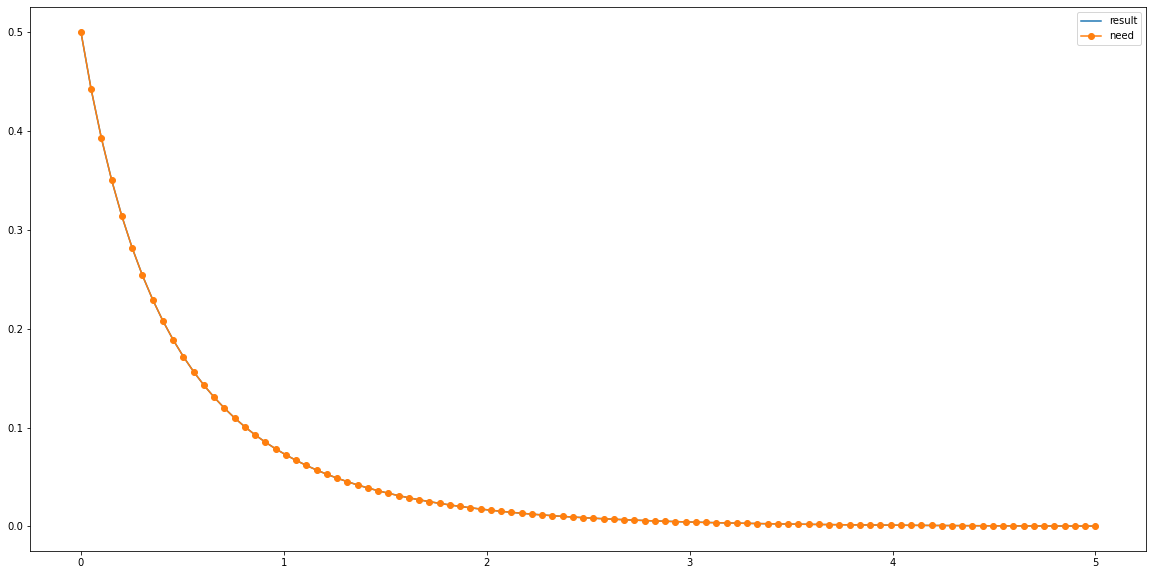

In [287]:
newton_points, newton_grads, newton_loss = newton(minimizing_func2, 1, start=start_point, lr_strategy=exp_lr,
                                                  epoch=2000)

print("Итераций", len(newton_points))

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-', label='result')
plt.plot(xs, ys, '-o', label='need')
plt.legend()


## DOGLEG

$m_k(p) = f(x_k) + \nabla f(x_k)^T p + \frac{1}{2} \cdot p^T H p$ \


Хотим делать шаг с одной стороны находя минимум этой модели, но с другой стороны, так как это какое то приближение нашей функции, в какой то окрестности точки оно хорошо работает, а если отдалиться от этой точки, то это приближение может довольно таки плохо приближать, и мы хотим чтобы наш шаг не был больше чем наш доверительный регион

То есть мы хотим найти $\displaystyle \min_{\|p\| \leq \Delta_k} m(p)$, где $\Delta_k$ - радиус доверительного региона.

$\displaystyle p^U = - \frac{\nabla f^T \nabla f}{\nabla f^T H \nabla f} \nabla f$ - минимум вдоль направления градиента \

$p^H$ = $\displaystyle - \frac{\nabla f}{H}$ - минимум квадратичной модели

Если минимум квадратичной модели лежит внутри нашего доверительного региона, то хорошо. Если снаружи, то надо найти какой-то шаг покороче.

Если вся собачья нога находится внутри доверительного региона, то мы шагаем туда. Если нет, то хотим найти пересечение ломанной с нашей сферой.

Если $p^U$ находится на расстоянии больше чем наш радиус, то находим их пересечение. Если меньше, то пересекаем отрезок между $p^U$ и $p^H$ со сферой

$\displaystyle \rho_k = \frac{f(x_k) - f(x_k + p_k)}{m_k(0) - m_k(p_k)}$

Если $\rho_k$ маленькое (возможно отрицательное), то модель плохо соответствует целевой функции, и доверительный регион нужно уменьшить
Если $\rho_k$ большое, то модель очень хорошо описывает функции, и доверительный регион можно увеличить



In [288]:
def getRo(f, x, p, calcH):
    fx = f(x) - f(x + p)
    mk = m(f, calcH, x, np.zeros(len(x))) - m(f, calcH, x, p)
    return fx / mk


def m(f, calcH, x, p):
    return f(x) + np.transpose(grad(f, x)) @ p + 1 / 2 * np.transpose(p) @ calcH(x) @ p


def calcHFor1(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    return 2 * JT @ JT.T


def calcStep(f, calcH, x, delta):
    H = calcH(x)
    gr = grad(f, x)

    pH = -np.linalg.inv(H) @ gr

    if np.linalg.norm(pH) <= delta:
        return pH

    pU = - (np.dot(gr, gr) / np.dot(gr, np.dot(H, gr))) * gr

    if np.linalg.norm(pU) >= delta:
        return delta * pU / np.linalg.norm(pU)

    A = pU
    B = pH - pU

    D4 = (A.T @ B) * (A.T @ B) - (B.T @ B) * (A.T @ A - delta * delta)

    T = (-A.T @ B + np.sqrt(D4)) / (B.T @ B)

    return A + T * B


def dogleg(f, start, calcH, delta=1, nu=1 / 4, epoch=20, delta_max=100):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):
        grads.append(np.linalg.norm(grad(f, x)))
        loss.append(f(x))

        p = calcStep(f, calcH, x, delta)

        ro = getRo(f, x, p, calcH)

        if ro < 1 / 4:
            delta = 1 / 4 * delta
        elif ro > 3 / 4 and np.linalg.norm(ro) == delta:
            delta = min(2 * delta, delta_max)
        else:
            delta = delta

        if ro > nu:
            x = x + p
        else:
            x = x

        points.append(x)

        if np.linalg.norm(grad(f, x)) < 1e-6:
            break

    return [np.array(points), np.array(grads), np.array(loss)]

In [289]:
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, calcHFor1, delta=2, epoch=1000)

# BFGS

$H$ - обратный гессиан

$p_k = -H_k \cdot \nabla f$ \

$x_{k+1} = x_k + \alpha p_k$

$\alpha находим с помощью линейного поиска с условиями Вольфе$\


$s_k = x_{k+1} - x_k$\ - шаг алгоритма на итерации $k$

$y_k = \nabla f_{k+1} - \nabla f_k$ - изменение градиента на итерации $k$

$H_{k+1} = (I - p_k s_k y_{k}^T) \cdot H_k \cdot (I - p_k y_k s_k^2) + p s_k s_k^T$, где $p_k = \frac {1} {y_k^T s_k}$

In [290]:
def gradient_func1(x):
    return np.array(minibatch_grad(minimizing_func, x))


def bfgs(f, grad_with_fixed_func, start, epoch):
    x = start

    points = list()
    grads = list()
    loss = list()

    points.append(x)

    I = np.eye(len(x))
    H = I

    gr = grad(f, x)
    loss.append(f(x))

    grads.append(np.linalg.norm(gr))
    for i in range(1, epoch):

        p = - H @ gr

        coef = opt.line_search(f, grad_with_fixed_func, x, p)[0]

        new_x = x + coef * p

        s = new_x - x
        x = new_x
        new_grad = grad(f, x)
        grads.append(np.linalg.norm(new_grad))
        loss.append(f(x))
        points.append(x)
        y = new_grad - gr

        if np.linalg.norm(grad(f, x)) < 1e-6:
            break

        gr = new_grad

        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y, (len(x), 1))
        s = np.reshape(s, (len(x), 1))

        ro = 1.0 / (y.T @ s)
        H = (I - ro * s @ y.T) @ H @ (I - ro * y @ s.T) + ro * s @ s.T

    return [points, grads, loss]

In [291]:
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)

In [292]:
d = {
    "Method": ['Gauss-Newton', 'GD', 'Adam', 'Dogleg', 'BFGS'],
    "Number of iterations": [len(newton_points), len(gd_points), len(adam_points), len(dogleg_points),
                             len(bfgs_points)],
    "Found": [newton_points[-1], gd_points[-1], adam_points[-1], dogleg_points[-1], bfgs_points[-1]],
    'Expected': [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]
}
pd.DataFrame(data=d)

,Method,Number of iterations,Found,Expected
0,Gauss-Newton,23,"[0.9999893983810338, 1.9999993143811314, 3.000...","[1, 2, 3]"
1,GD,24261,"[0.9999849797706837, 1.9999965754579587, 3.000...","[1, 2, 3]"
2,Adam,627,"[1.0000001712290085, 2.000000203534374, 3.0000...","[1, 2, 3]"
3,Dogleg,1000,"[0.9938266158842225, 1.9985870855297783, 3.029...","[1, 2, 3]"
4,BFGS,21,"[0.9999958973000072, 2.000000586202001, 3.0000...","[1, 2, 3]"


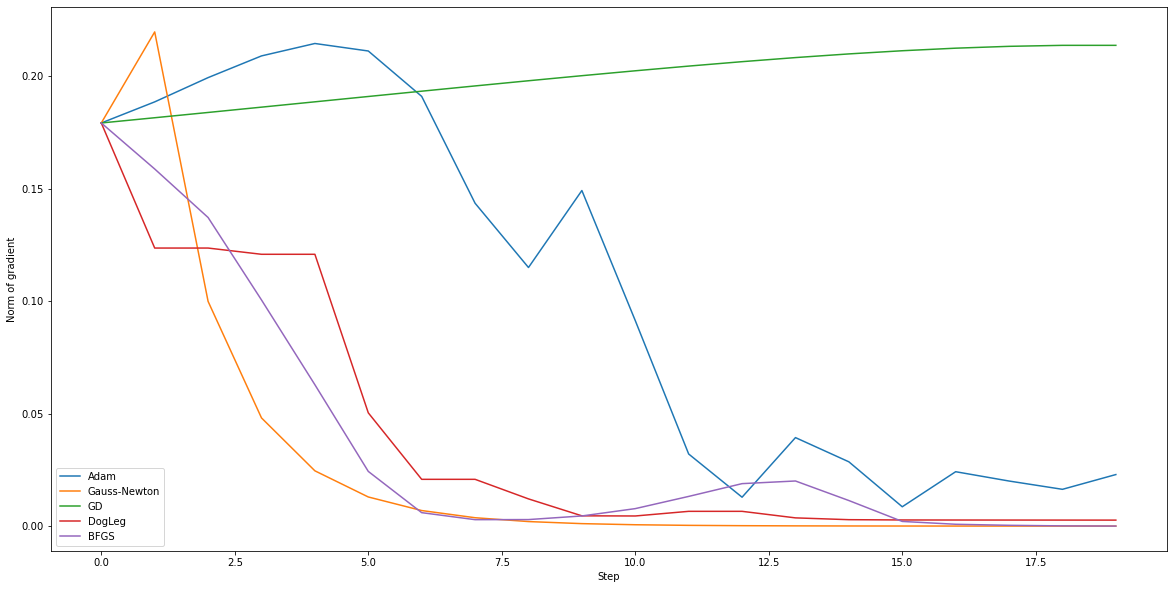

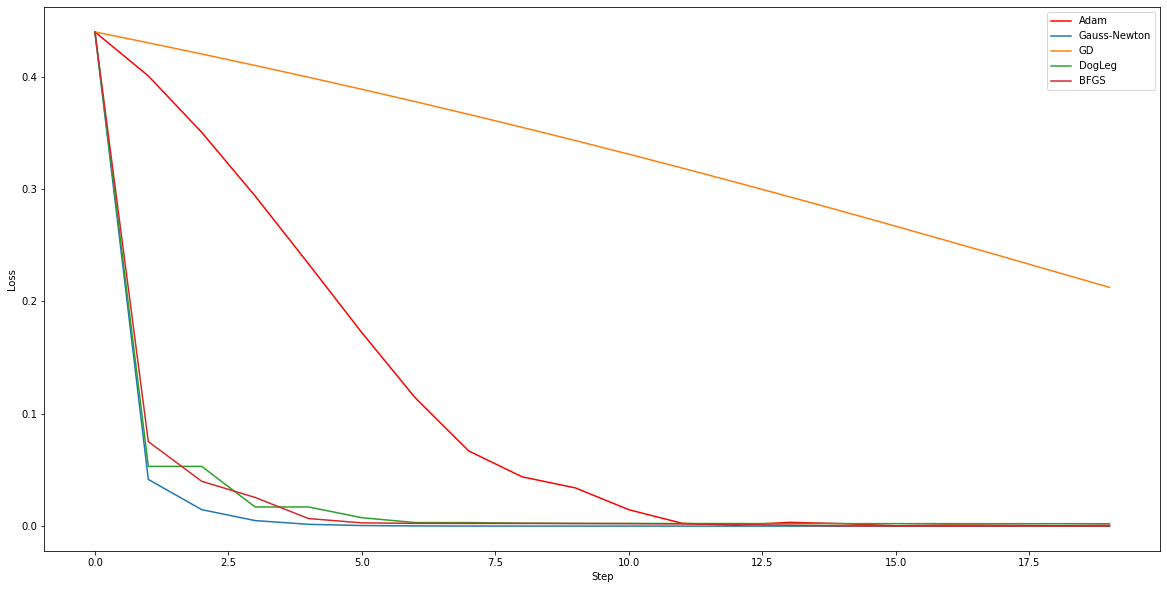

In [293]:
size = min(len(gd_points), len(adam_points), len(newton_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_grads[:size], label='Adam')
plt.plot(ss, newton_grads[:size], label='Gauss-Newton')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

plt.plot(ss, adam_loss[:size], 'r', label='Adam')
plt.plot(ss, newton_loss[:size], label='Gauss-Newton')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

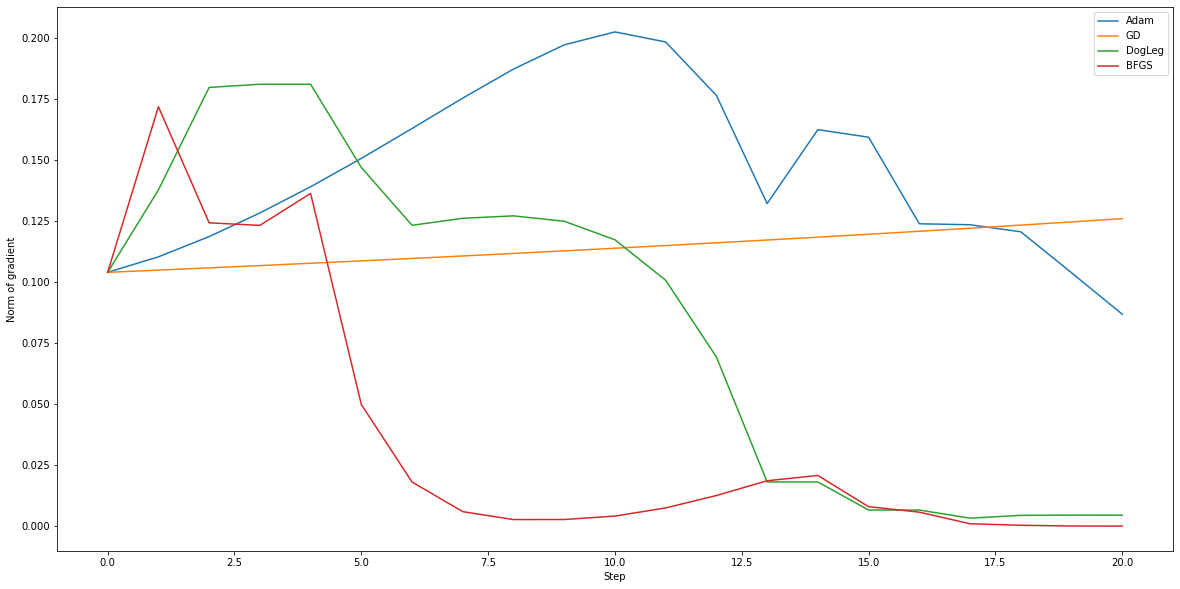

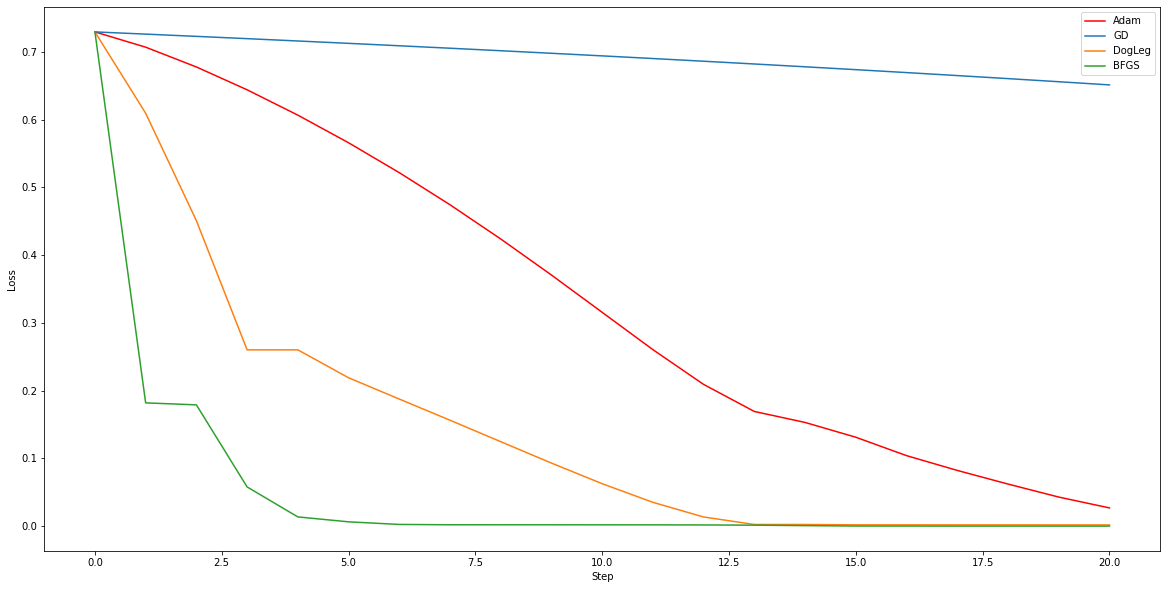

In [294]:
start_point = [3, 6, 5]

gd_points, gd_grads, gd_loss = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)
adam_points, adam_grads, adam_loss = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point,
                                          lr_strategy=exp_lr, epoch=50000, batch=30)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(minimizing_func, gradient_func1, start_point, epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(minimizing_func, start_point, calcHFor1, delta=1, epoch=1000)

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_grads[:size], label='Adam')
plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, adam_loss[:size], 'r', label='Adam')
plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

In [295]:
d = {
    "Method": ['Gauss-Newton', 'GD', 'Adam', 'Dogleg', 'BFGS'],
    "Number of iterations": ['inf', len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)],
    "Found": ['inf', gd_points[-1], adam_points[-1], dogleg_points[-1], bfgs_points[-1]],
    'Expected': [[3, 6, 5], [3, 6, 5], [3, 6, 5], [3, 6, 5], [3, 6, 5]]
}
pd.DataFrame(data=d)

,Method,Number of iterations,Found,Expected
0,Gauss-Newton,inf,inf,"[3, 6, 5]"
1,GD,24081,"[0.9999849818109496, 1.9999965759231337, 3.000...","[3, 6, 5]"
2,Adam,538,"[0.9999989853087893, 1.9999991777109587, 3.000...","[3, 6, 5]"
3,Dogleg,1000,"[0.9946516026656443, 1.9987689186038957, 3.025...","[3, 6, 5]"
4,BFGS,22,"[0.9999999434799742, 2.0000002159576598, 3.000...","[3, 6, 5]"


In [296]:
def func2(x):
    return x[0] ** 2 - x[0] * x[1] + x[1] ** 2 + 7 * x[0] - 5 * x[1] + 11


def gradient_func2(x):
    return np.array([2 * x[0] - x[1] + 7, -x[0] + 2 * x[1] - 5])


def hessian_func2(x):
    return np.array(([2, -1], [-1, 2]))

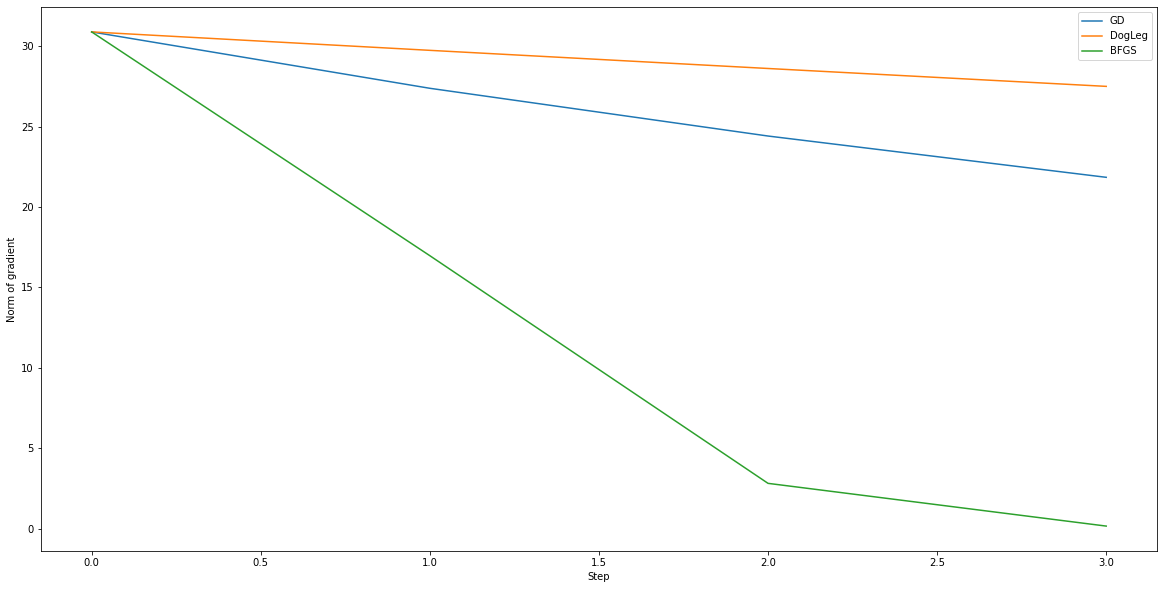

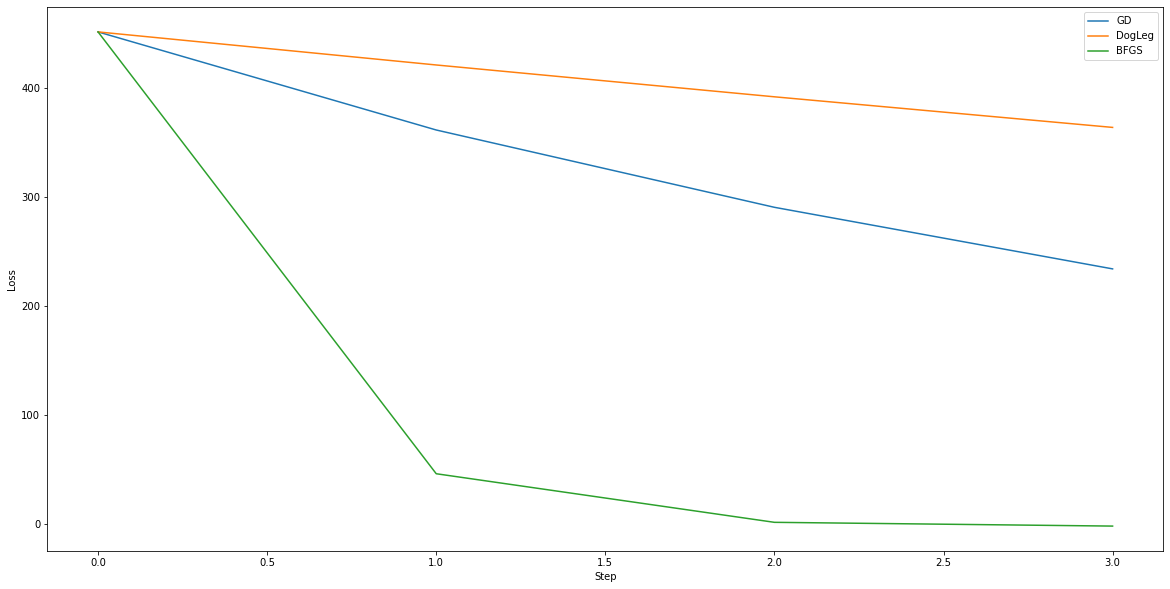

In [297]:
start_point = [20, 20]

gd_points, gd_grads, gd_loss = gd(func2, 0.1, [20, 20], const_lr, 1000)
bfgs_points, bfgs_grads, bfgs_loss = bfgs(func2, gradient_func2, start=[20, 20], epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(func2, [20, 20], hessian_func2, delta=1, epoch=1000)

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, gd_grads[:size], label='GD')
plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

size = min(len(gd_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, gd_loss[:size], label='GD')
plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

In [298]:
def rosenbrok(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2


def rosenbrok_grad(x):
    return np.array([2 * (200 * x[0] ** 3 - 200 * x[0] * x[1] + x[0] - 1), 200 * (x[1] - x[0] ** 2)])


def rosenbrok_hess(x):
    return np.array(([-400 * (x[1] - x[0] ** 2) + 800 * x[0] ** 2 + 2, -400 * x[0]], [-400 * x[0], 200]))

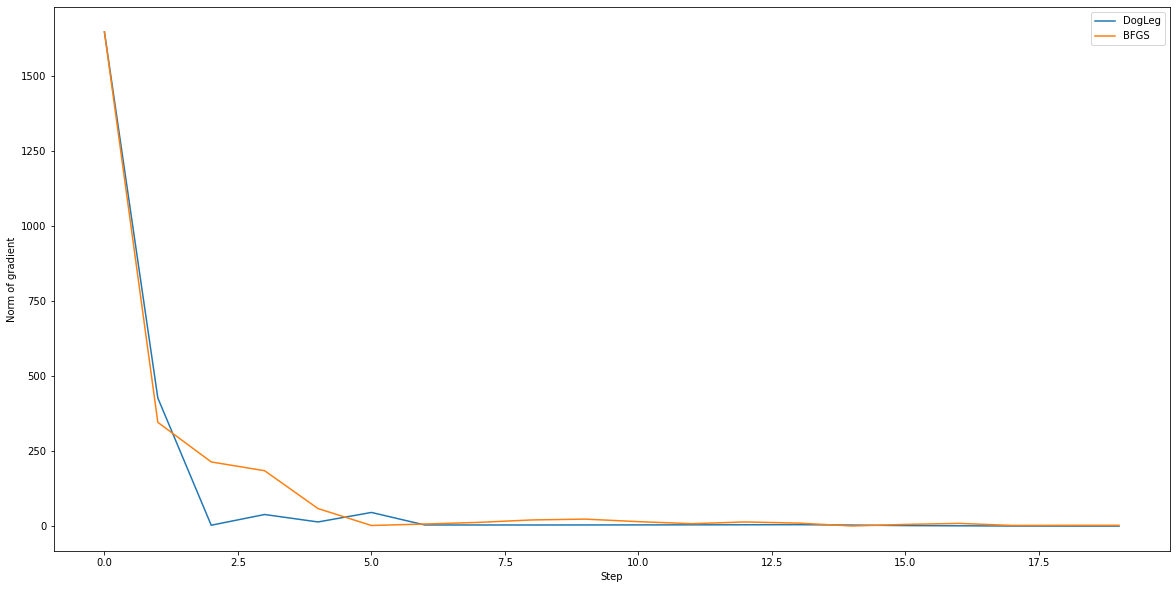

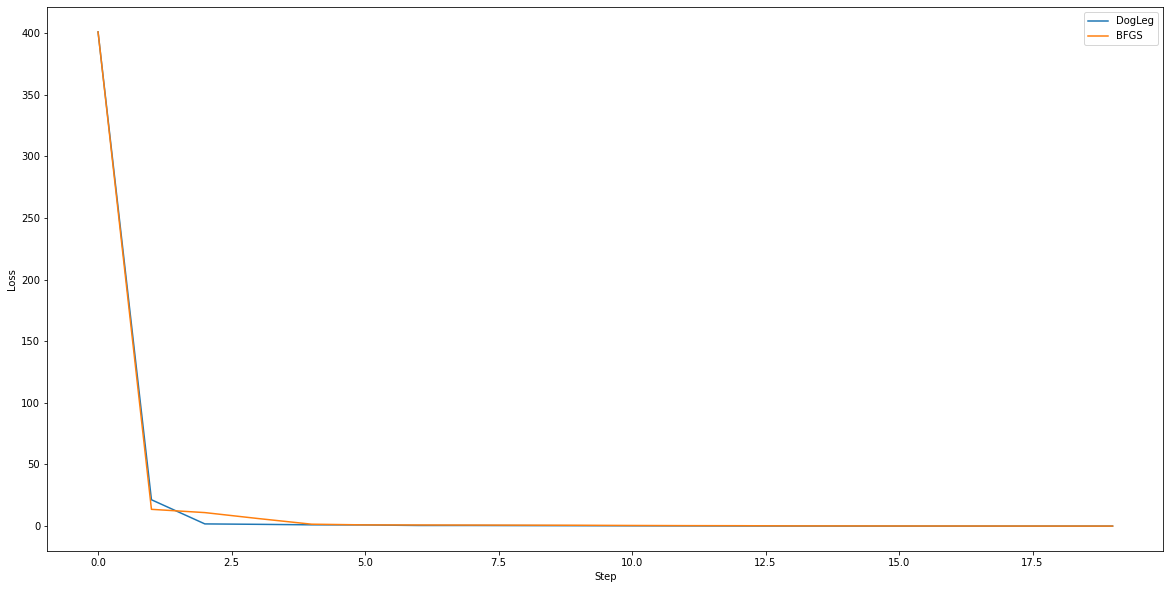

In [309]:
start_point = [2, 6]

bfgs_points, bfgs_grads, bfgs_loss = bfgs(rosenbrok, rosenbrok_grad, start=start_point, epoch=1000)
dogleg_points, dogleg_grads, dogleg_loss = dogleg(rosenbrok, start_point, rosenbrok_hess, delta=1, epoch=1000)

size = min(len(gd_points), len(adam_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, dogleg_grads[:size], label='DogLeg')
plt.plot(ss, bfgs_grads[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

plt.show()

size = min(len(gd_points), len(dogleg_points), len(bfgs_points)) - 1
ss = range(0, size)

plt.plot(ss, dogleg_loss[:size], label='DogLeg')
plt.plot(ss, bfgs_loss[:size], label='BFGS')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

In [310]:
bfgs_points

[[2.0, 6.000000000000004],
 array([2.49276367, 5.8766549 ]),
 array([1.55182654, 2.08189659]),
 array([1.99956286, 4.22451277]),
 array([2.00106511, 4.07744453]),
 array([1.98572427, 3.94302933]),
 array([1.95125045, 3.80114884]),
 array([1.90164769, 3.60285139]),
 array([1.83060225, 3.32627509]),
 array([1.76258538, 3.07695788]),
 array([1.68453212, 2.81848024]),
 array([1.60121837, 2.55370583]),
 array([1.52379827, 2.30203756]),
 array([1.37088902, 1.86352501]),
 array([1.36448999, 1.86324679]),
 array([1.26888672, 1.60081264]),
 array([1.19878402, 1.42051959]),
 array([1.18161533, 1.39268485]),
 array([1.12171135, 1.25355727]),
 array([1.06968773, 1.13895539]),
 array([1.04656416, 1.09696113]),
 array([1.00555456, 1.00832971]),
 array([1.01559547, 1.03126662]),
 array([1.00821004, 1.01627233]),
 array([1.00047127, 1.00080058]),
 array([1.00011722, 1.00022579]),
 array([1.00000067, 1.00000124]),
 array([1.        , 1.00000001])]